## Imports

In [1]:
import torch
from torch.utils.data import DataLoader

from src.utils_data import load_PeMS04_flow_data, preprocess_PeMS_data, createLoaders, TimeSeriesDataset
from src.utils_graph import compute_laplacian_with_self_loop
from src.models import TGCN, GRUModel, LSTMModel, train_model

import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Print Results

In [2]:
def result_prediction(predictions, actuals):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    
    indices_by_month = []
    EPSILON = 1e-5
    # Créer une liste vide pour stocker les données du tableau
    data = []
    y_pred = predictions[:]
    y_true = actuals[:]

    signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    if (mape > 1 or mape < 0):
        mape = "ERROR"
    smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
    maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100
    
    return [signe, mae, rmse, mape, smape, maape]

In [3]:
def highlight_rows(row, min_val, max_val):
    if row["MAAPE"] == min_val:
        color = "green"
    elif row["MAAPE"] == max_val:
        color = "red"
    else:
        color = ""
    return [f'background-color: {color}'] * len(row)

In [ ]:
import matplotlib.pyplot as plt
def plot_losses(losses, title, label_line):
    plt.figure(figsize=(25, 9))
    plt.title(title)
    plt.plot(losses, label=label_line)
    plt.legend(fontsize=12)
    plt.show()

## create_multiple_model_with_one_captor

In [ ]:
import copy
def create_multiple_model_with_one_captor(model, nb_model, name_dict, data, _windows_size, _stride):
    dict_model = {}
    for i in range(nb_model):
        #print(f"{name_dict}{i}")
        train_loader, val_loader, test_loader = createLoaders(pd.DataFrame(data.iloc[:, i]), window_size=_windows_size, stride=_stride, target_size=horizon)
        dict_model[f"{name_dict}{i}"] = {
                                "model": copy.deepcopy(model),
                                "train_loader": train_loader,
                                "val_loader": val_loader,
                                "test_loader": test_loader
        }
    return dict_model

## Test Model

In [4]:
def test_model(best_model, test_loader):
    import numpy as np
    
    # Load the best model and evaluate on the test set
    criterion = torch.nn.MSELoss()
    best_model.double()
    best_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model.to(device)

    # Evaluate the model on the test set
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size, horizon_size, num_nodes = targets.size()
            final_output = torch.empty((batch_size, 0, num_nodes)).to(device)
            outputs = best_model(inputs.double())
            final_output = torch.cat([final_output, outputs.unsqueeze(1)], dim=1)
            for i in range(1, horizon_size):
                outputs = best_model(torch.cat((inputs[:, i:, :], final_output[:, -1, :].unsqueeze(1)), dim=1))
                final_output = torch.cat([final_output, outputs.unsqueeze(1)], dim=1)
            loss = criterion(final_output, targets)
            test_loss += loss.item()
            # Save the predictions and actual values for plotting later
            predictions.append(final_output.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    test_loss /= len(test_loader)
    # print(f"Test Loss: {test_loss:.4f}")
    
    # Concatenate the predictions and actuals
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return (predictions, actuals)

## Parameters

In [5]:
################################################################################
# EPOCHS
################################################################################
n_neighbors = 49
normalization = "center_and_reduce"

_window_size = 6
horizon = 6
_stride = 1

################################################################################
# PATH
################################################################################
path_save_model = f"./{normalization}/nb_captor_{n_neighbors+1}/windows_{_window_size}_out_{horizon}"

################################################################################
# EPOCHS
################################################################################
# Univariate
num_epochs_LSTM_univariate = 3
num_epochs_GRU_univaritate = 3

# Multivariate
num_epochs_TGCN = 300
num_epochs_LSTM_multivariate = 300
num_epochs_GRU_multivariate = 300

## Preprocessing data

In [6]:
df_PeMS_old, df_distance  = load_PeMS04_flow_data()
df_PeMS, adjacency_matrix_PeMS, meanstd_dict = preprocess_PeMS_data(df_PeMS_old, df_distance, init_node=0, n_neighbors=n_neighbors, center_and_reduce=True)

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


## TGCN

In [ ]:
import copy
def create_multiple_model_with_one_captor(model, nb_model, name_dict, data, _windows_size, _stride):
    dict_model = {}
    for i in range(nb_model):
        #print(f"{name_dict}{i}")
        train_loader, val_loader, test_loader = createLoaders(pd.DataFrame(data.iloc[:, i]), window_size=_windows_size, stride=_stride, target_size=horizon)
        dict_model[f"{name_dict}{i}"] = {
                                "model": copy.deepcopy(model),
                                "train_loader": train_loader,
                                "val_loader": val_loader,
                                "test_loader": test_loader
        }
    return dict_model

In [9]:
train_loader_TGCN, val_loader_TGCN, test_loader_TGCN = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
model_TGCN = TGCN(adjacency_matrix_PeMS, hidden_dim=32, output_size=len(df_PeMS.columns))

In [10]:
# import matplotlib.pyplot as plt

# model_path = f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl"
# _ , valid_losses, train_losses = train_model(model_TGCN, train_loader_TGCN, val_loader_TGCN, model_path=model_path, num_epochs=num_epochs_TGCN, remove=False)

# plot_losses(train_losses, "TGCN train_losses", "train_losses")
# plot_losses(valid_losses, "TGCN valid losses", "valid_losses")


## Univariate 

In [11]:
# # LSTM
# models_univaritate_LSTM = {}

# # GRU
# models_univaritate_GRU = {}

In [12]:
# # LSTM
# models_univaritate_LSTM = create_multiple_model_with_one_captor(LSTMModel(1,32,1), n_neighbors+1, "LSTMModel", df_PeMS, _window_size, _stride)

# for i in range(n_neighbors+1):
#     _, valid_losses, train_losses = train_model(models_univaritate_LSTM[f"LSTMModel{i}"]["model"], 
#                 models_univaritate_LSTM[f"LSTMModel{i}"]["train_loader"], 
#                 models_univaritate_LSTM[f"LSTMModel{i}"]["val_loader"], 
#                 f"{path_save_model}/epoch_{num_epochs_LSTM_univariate}/univariate_LSTM_model_{i}.pkl", num_epochs=num_epochs_LSTM_univariate, remove=False)
#     plot_losses(train_losses, f"LSTM train_losses captor {df_PeMS.columns[i]}", "train_losses")
#     plot_losses(valid_losses, f"LSTM valid_losses captor {df_PeMS.columns[i]}", "valid_losses")


# # GRU
# models_univaritate_GRU = create_multiple_model_with_one_captor(GRUModel(1, 32, 1), n_neighbors+1, "GRUModel", df_PeMS, _window_size, _stride)

# for i in range(n_neighbors+1):
#     _, valid_losses, train_losses = train_model(models_univaritate_GRU[f"GRUModel{i}"]["model"], 
#             models_univaritate_GRU[f"GRUModel{i}"]["train_loader"], 
#             models_univaritate_GRU[f"GRUModel{i}"]["val_loader"], 
#             f"{path_save_model}/epoch_{num_epochs_GRU_univaritate}/univariate_GRU_model_{i}.pkl", num_epochs=num_epochs_GRU_univaritate, remove=False)
#     plot_losses(train_losses, f"GRU train_losses captor {df_PeMS.columns[i]}", "train_losses")
#     plot_losses(valid_losses, f"GRU valid_losses captor {df_PeMS.columns[i]}", "valid_losses")

## Results Multivariate vs Univariate (TGCN VS LSTM - GRU)

In [13]:
# import matplotlib.pyplot as plt
# ######################################################################
# # TGCN
# ######################################################################
# # load best model
# model_TGCN.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl".format(input)))

# # Make predictions
# predictions_TGCN, actuals_TGCN = test_model(model_TGCN, test_loader_TGCN)


# for i in range(n_neighbors+1):
#     # Save result for each captor
#     temp = result_prediction(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                             actuals_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
#     temp.append(f"TGCN Model captor {df_PeMS.columns[i]}")
#     data = [temp]


# ######################################################################
# # LSTM
# ######################################################################
#     # load best model
#     models_univaritate_LSTM[f"LSTMModel{i}"]["model"].load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_LSTM_univariate}/univariate_LSTM_model_{i}.pkl".format(input)))
    
#     # Make predictions
#     predictions_LSTM, actuals_LSTM = test_model(models_univaritate_LSTM[f"LSTMModel{i}"]["model"], 
#                                     models_univaritate_LSTM[f"LSTMModel{i}"]["test_loader"])

#     # Save result
#     temp = result_prediction(predictions_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                             actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

#     temp.append(f"LSTM Model captor {df_PeMS.columns[i]}")
#     data.append(temp)


# ######################################################################
# # GRU
# ######################################################################
#     # Load best model
#     models_univaritate_GRU[f"GRUModel{i}"]["model"].load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_GRU_univaritate}/univariate_GRU_model_{i}.pkl".format(input)))
#     predictions_GRU, actuals_GRU = test_model(models_univaritate_GRU[f"GRUModel{i}"]["model"], 
#                                     models_univaritate_GRU[f"GRUModel{i}"]["test_loader"])

#     # Make predictions
#     temp = result_prediction(predictions_GRU * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"]
#                             , actuals_GRU * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

#     # Save results
#     temp.append(f"GRU Model captor {df_PeMS.columns[i]}")
#     data.append(temp)


# ######################################################################
# # Dataframe
# ######################################################################
#     df = pd.DataFrame(data, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Captor"])

#     # Définir le mois comme index du DataFrame
#     df.set_index('Captor', inplace=True)

#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_rows', None)
#     pd.set_option('display.width', None)

#     min_val = df['MAAPE'].min()
#     max_val = df['MAAPE'].max()

#     df = df.style.apply(highlight_rows, axis=1, min_val=min_val, max_val=max_val)
#     display(df)


# ######################################################################
# # Plots
# ######################################################################
#     plt.figure(figsize=(21, 10))
#     plt.plot(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="orange", label="TGCN pred")
#     plt.plot(actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()
    
#     plt.figure(figsize=(21, 10))
#     plt.plot(predictions_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="magenta", label="LSTM pred")
#     plt.plot(actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()
    
#     plt.figure(figsize=(21, 10))
#     plt.plot(predictions_GRU * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="red", label="GRU pred" )
#     plt.plot(actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()


## Multivariate

In [14]:
# LSTM
num_epochs_LSTM_multivariate = 300

# GRU
num_epochs_GRU_multivariate = 300

In [15]:
# # LSTM
# model_multivariate_LSTM = LSTMModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
# train_loader_LSTM, val_loader_LSTM, test_loader_LSTM = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
# _ , valid_losses, train_losses = train_model(model_multivariate_LSTM, train_loader_LSTM, val_loader_LSTM, 
#                                             f"./{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl", 
#                                             num_epochs=num_epochs_LSTM_multivariate, remove=False)
# plot_losses(train_losses, "LSTM train_losses", "train_losses")
# plot_losses(valid_losses, "LSTM valid losses", "valid_losses")

# # GRU
# model_multivariate_GRU = GRUModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
# train_loader_GRU, val_loader_GRU, test_loader_GRU = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
# _ , valid_losses, train_losses = train_model(model_multivariate_GRU, train_loader_GRU, val_loader_GRU, 
#                                             f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl", 
#                                             num_epochs=num_epochs_GRU_multivariate, remove=False)
# plot_losses(train_losses, "GRU train_losses", "train_losses")
# plot_losses(valid_losses, "GRU valid losses", "valid_losses")

## Results Multivariate vs Multivariate (TGCN VS LSTM - GRU)

In [16]:
# import matplotlib.pyplot as plt

# final_resultats = []
# diff_resultats = []

# ######################################################################
# # TGCN
# ######################################################################
# # load best model
# model_TGCN.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl".format(input)))

# # Make predictions
# predictions_TGCN, actuals_TGCN = test_model(model_TGCN, test_loader_TGCN)

# nb_row, _, _ = predictions_TGCN.shape
# predictions_TGCN = predictions_TGCN.reshape(nb_row * horizon, n_neighbors+1)
# actuals_TGCN = actuals_TGCN.reshape(nb_row * horizon, n_neighbors+1)

# ######################################################################
# # LSTM
# ######################################################################
# # load best model
# model_multivariate_LSTM.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl".format(input)))
    
# # Make predictions
# predictions_LSTM, actuals_LSTM = test_model(model_multivariate_LSTM, 
#                                 test_loader_LSTM)

# predictions_LSTM = predictions_LSTM.reshape(nb_row * horizon, n_neighbors+1)
# actuals_LSTM = actuals_LSTM.reshape(nb_row * horizon, n_neighbors+1)


# ######################################################################
# # GRU
# ######################################################################
# # Load best model
# model_multivariate_GRU.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl".format(input)))

# # Make predictions
# predictions_GRU, actuals_GRU = test_model(model_multivariate_GRU, 
#                                 test_loader_GRU)

# predictions_GRU = predictions_GRU.reshape(nb_row * horizon, n_neighbors+1)
# actuals_GRU = actuals_GRU.reshape(nb_row * horizon, n_neighbors+1)

# for i in range(n_neighbors+1):

# ######################################################################
# # TGCN
# ######################################################################
#     # Save result for each captor
#     temp = result_prediction(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                             actuals_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
#     temp.append("TGCN Model")
#     temp.append(f"captor {df_PeMS.columns[i]}")
#     data = [temp]
#     final_resultats.append(temp)

# ######################################################################
# # LSTM
# ######################################################################
#     # Save result
#     temp = result_prediction(predictions_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                             actuals_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

#     temp.append("LSTM Model")
#     temp.append(f"captor {df_PeMS.columns[i]}")
#     data.append(temp)
#     final_resultats.append(temp)


# ######################################################################
# # GRU
# ######################################################################
#     # Save results
#     temp = result_prediction(predictions_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                             actuals_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
#     temp.append("GRU Model")
#     temp.append(f"captor {df_PeMS.columns[i]}")
#     data.append(temp)
#     final_resultats.append(temp)


# ######################################################################
# # Dataframe
# ######################################################################
#     df = pd.DataFrame(data, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])

#     df.set_index(["Captor", 'Model_Name'], inplace=True)

#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_rows', None)
#     pd.set_option('display.width', None)

#     min_val = df['MAAPE'].min()
#     max_val = df['MAAPE'].max()

#     df = df.style.apply(highlight_rows, axis=1, min_val=min_val, max_val=max_val)

# #######################################################################
# # Plots
# #######################################################################
# final_resultats = pd.DataFrame(final_resultats, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])
# final_resultats.set_index(["Captor", 'Model_Name'], inplace=True)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.width', None)
# display(final_resultats.groupby("Model_Name")[["RMSE", "SMAPE", "MAAPE"]].describe())
# final_resultats.to_pickle(f"{path_save_model}/final_resultats.pkl")

# stats = {
#     "TGCN Model" : {"nb_win" : 0},
#     "LSTM Model" : {"nb_win" : 0},
#     "GRU Model" :  {"nb_win" : 0}
# }

# for i in final_resultats.index.get_level_values("Captor").unique():
#     stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] = stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] + 1
#     diff_resultats.append(["TGCN vs LSTM", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
#     diff_resultats.append(["TGCN vs GRU", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
#     diff_resultats.append(["LSTM vs TGCN", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
#     diff_resultats.append(["LSTM vs GRU", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
#     diff_resultats.append(["GRU vs TGCN", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
#     diff_resultats.append(["GRU vs LSTM", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
# diff_resultats = pd.DataFrame(diff_resultats, columns=["Diff", "MAAPE"])
# diff_resultats.set_index(["Diff"], inplace=True)
# display(diff_resultats.groupby("Diff").describe())
# diff_resultats.groupby("Diff").describe().to_pickle(f"{path_save_model}/diff_results.pkl")

# import numpy as np

# bar_plot_results = final_resultats.reset_index()
# display(bar_plot_results.boxplot(column="MAAPE", by="Model_Name", fontsize=10, figsize=(8,8), ylabel="MAAPE values", xlabel="Model Name"))
# plt.yticks(np.arange(0, bar_plot_results["MAAPE"].max(), 4))

In [17]:
# final_resultats = pd.read_pickle(f"{path_save_model}/final_resultats.pkl")
# display(final_resultats.groupby("Model_Name")[["RMSE", "SMAPE", "MAAPE"]].describe())
# diff_results = pd.read_pickle(f"{path_save_model}/diff_results.pkl")
# display(diff_results)

# bar_plot_results = final_resultats.reset_index()
# display(bar_plot_results.boxplot(column="MAAPE", by="Model_Name", fontsize=10, figsize=(8,8), ylabel="MAAPE values", xlabel="Model Name"))
# plt.yticks(np.arange(0, bar_plot_results["MAAPE"].max(), 4))

## Multi_Experiments

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


RMSE                                                        \
           count       mean        std       min        25%        50%   
Model_Name                                                               
GRU Model   51.0  32.192696  28.631382  8.989630  20.583158  26.975131   
LSTM Model  51.0  31.493124  28.801416  8.362087  19.947054  25.424029   
TGCN Model  51.0  27.575517  15.065217  6.035083  19.201302  25.513029   

                                  SMAPE                                 \
                  75%         max count       mean       std       min   
Model_Name                                                               
GRU Model   35.041100  181.547612  51.0  11.461271  8.595212  4.991939   
LSTM Model  34.468348  182.913168  51.0  10.874954  8.644889  4.794218   
TGCN Model  30.413017   89.280861  51.0  10.743445  6.896238  4.710677   

                                                     MAAPE             \
                 25%       50%        75%        max count       mean   
Model_Name                                                              
GRU Model   7.650695  8.256271  11.067641  54.973641  51.0  11.323788   
LSTM Model  7.122284  7.629752  10.204387  56.148423  51.0  10.683543   
TGCN Model  6.959181  8.346986  10.446134  37.918104  51.0  10.363520   

                                                                          
                 std       min       25%       50%        75%        max  
Model_Name                                                                
GRU Model   8.618954  5.082950  7.510114  8.402156  11.088040  60.398061  
LSTM Model  8.654204  4.818167  7.112780  7.707435  10.537491  61.260720  
TGCN Model  6.041047  4.637485  6.852927  8.351071  10.527236  33.119601

MAAPE                                                      
             count      mean       std    min    25%   50%    75%    max
Diff                                                                    
GRU vs LSTM   51.0  0.639804  0.856139  -1.50  0.105  0.58  1.120   4.17
GRU vs TGCN   51.0  0.960392  5.247406  -8.82 -0.455  0.56  1.515  32.97
LSTM vs GRU   51.0 -0.639804  0.856139  -4.17 -1.120 -0.58 -0.105   1.50
LSTM vs TGCN  51.0  0.319804  5.541991 -10.62 -1.570 -0.23  1.305  33.83
TGCN vs GRU   51.0 -0.960392  5.247406 -32.97 -1.515 -0.56  0.455   8.82
TGCN vs LSTM  51.0 -0.319804  5.541991 -33.83 -1.305  0.23  1.570  10.62

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

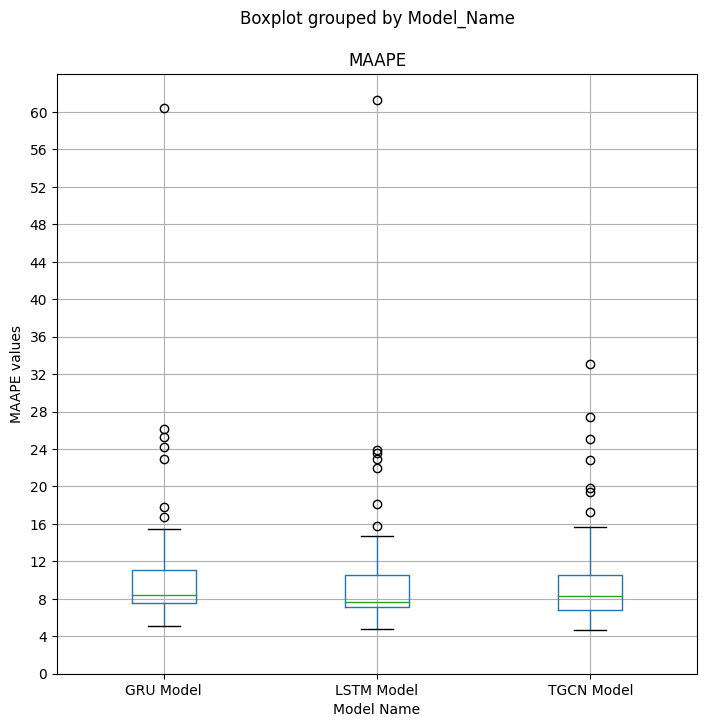

In [18]:
import matplotlib.pyplot as plt

# Not a parameter just the name of normalization use in preprocess_PeMS_data()
normalization = "center_and_reduce"

# Define the sliding window size, stride and horizon
_window_size = 6
horizon = 6
_stride = 1

# TGCN
num_epochs_TGCN = 300
# LSTM
num_epochs_LSTM_multivariate = 300
# GRU
num_epochs_GRU_multivariate = 300

for i in range(10, 100, 10):
    n_neighbors = i
    path_save_model = f"./{normalization}/nb_captor_{n_neighbors+1}/windows_{_window_size}_out_{horizon}"
    df_PeMS, adjacency_matrix_PeMS, meanstd_dict = preprocess_PeMS_data(df_PeMS_old, df_distance, init_node=0, n_neighbors=n_neighbors, center_and_reduce=True)
    
    # TGCN
    train_loader_TGCN, val_loader_TGCN, test_loader_TGCN = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
    model_TGCN = TGCN(adjacency_matrix_PeMS, hidden_dim=32, output_size=len(df_PeMS.columns))

    model_path = f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl"
    _ , _, _ = train_model(model_TGCN, train_loader_TGCN, val_loader_TGCN, model_path=model_path, num_epochs=num_epochs_TGCN, remove=False)


    # LSTM
    model_multivariate_LSTM = LSTMModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
    train_loader_LSTM, val_loader_LSTM, test_loader_LSTM = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
    _ , _, _ = train_model(model_multivariate_LSTM, train_loader_LSTM, val_loader_LSTM, 
                                                f"{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl", 
                                                num_epochs=num_epochs_LSTM_multivariate, remove=False)

    # GRU
    model_multivariate_GRU = GRUModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
    train_loader_GRU, val_loader_GRU, test_loader_GRU = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
    _ , _, _ = train_model(model_multivariate_GRU, train_loader_GRU, val_loader_GRU, 
                                                f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl", 
                                                num_epochs=num_epochs_GRU_multivariate, remove=False)


    final_resultats = []
    diff_resultats = []

    ######################################################################
    # TGCN
    ######################################################################
    # load best model
    model_TGCN.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl".format(input)))

    # Make predictions
    predictions_TGCN, actuals_TGCN =  test_model(model_TGCN, test_loader_TGCN)

    nb_row, _, _ = predictions_TGCN.shape
    predictions_TGCN = predictions_TGCN.reshape(nb_row * horizon, n_neighbors+1)
    actuals_TGCN = actuals_TGCN.reshape(nb_row * horizon, n_neighbors+1)


    ######################################################################
    # LSTM
    ######################################################################
    # load best model
    model_multivariate_LSTM.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl".format(input)))
        
    # Make predictions
    predictions_LSTM, actuals_LSTM = test_model(model_multivariate_LSTM, 
                                    test_loader_LSTM)
    
    predictions_LSTM = predictions_LSTM.reshape(nb_row * horizon, n_neighbors+1)
    actuals_LSTM = actuals_LSTM.reshape(nb_row * horizon, n_neighbors+1)


    ######################################################################
    # GRU
    ######################################################################
    # Load best model
    model_multivariate_GRU.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl".format(input)))

    # Make predictions
    predictions_GRU, actuals_GRU = test_model(model_multivariate_GRU, 
                                    test_loader_GRU)
    
    predictions_GRU = predictions_GRU.reshape(nb_row * horizon, n_neighbors+1)
    actuals_GRU = actuals_GRU.reshape(nb_row * horizon, n_neighbors+1)

    for i in range(n_neighbors+1):

    ######################################################################
    # TGCN
    ######################################################################
        # Save result for each captor
        temp = result_prediction(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
                                actuals_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
        temp.append("TGCN Model")
        temp.append(f"captor {df_PeMS.columns[i]}")
        data = [temp]
        final_resultats.append(temp)

    ######################################################################
    # LSTM
    ######################################################################
        # Save result
        temp = result_prediction(predictions_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
                                actuals_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

        temp.append("LSTM Model")
        temp.append(f"captor {df_PeMS.columns[i]}")
        data.append(temp)
        final_resultats.append(temp)


    ######################################################################
    # GRU
    ######################################################################
        # Save results
        temp = result_prediction(predictions_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
                                actuals_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
        temp.append("GRU Model")
        temp.append(f"captor {df_PeMS.columns[i]}")
        data.append(temp)
        final_resultats.append(temp)


    ######################################################################
    # Dataframe
    ######################################################################
        df = pd.DataFrame(data, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])

        df.set_index(["Captor", 'Model_Name'], inplace=True)

        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_rows', None)
        pd.set_option('display.width', None)

        min_val = df['MAAPE'].min()
        max_val = df['MAAPE'].max()

        df = df.style.apply(highlight_rows, axis=1, min_val=min_val, max_val=max_val)

    #######################################################################
    # Plots
    #######################################################################
    final_resultats = pd.DataFrame(final_resultats, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])
    final_resultats.set_index(["Captor", 'Model_Name'], inplace=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', None)
    display(final_resultats.groupby("Model_Name")[["RMSE", "SMAPE", "MAAPE"]].describe())
    final_resultats.to_pickle(f"{path_save_model}/final_resultats.pkl")

    stats = {
        "TGCN Model" : {"nb_win" : 0},
        "LSTM Model" : {"nb_win" : 0},
        "GRU Model" :  {"nb_win" : 0}
    }

    for i in final_resultats.index.get_level_values("Captor").unique():
        stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] = stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] + 1
        diff_resultats.append(["TGCN vs LSTM", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
        diff_resultats.append(["TGCN vs GRU", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
        diff_resultats.append(["LSTM vs TGCN", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
        diff_resultats.append(["LSTM vs GRU", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
        diff_resultats.append(["GRU vs TGCN", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
        diff_resultats.append(["GRU vs LSTM", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
    diff_resultats = pd.DataFrame(diff_resultats, columns=["Diff", "MAAPE"])
    diff_resultats.set_index(["Diff"], inplace=True)
    display(diff_resultats.groupby("Diff").describe())
    diff_resultats.groupby("Diff").describe().to_pickle(f"{path_save_model}/diff_results.pkl")

    import numpy as np

    bar_plot_results = final_resultats.reset_index()
    display(bar_plot_results.boxplot(column="MAAPE", by="Model_Name", fontsize=10, figsize=(8,8), ylabel="MAAPE values", xlabel="Model Name"))
    plt.yticks(np.arange(0, bar_plot_results["MAAPE"].max(), 4))